In [1]:
import os
import numpy as np
from scipy import ndimage
import SimpleITK as sitk
import matplotlib.pyplot as plt
get_ipython().magic('pylab inline')

import FunctionsCustom as fun

Populating the interactive namespace from numpy and matplotlib


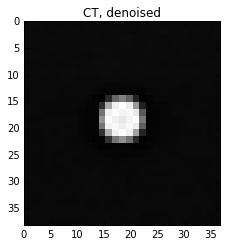

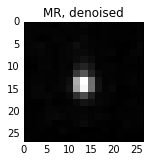

In [2]:
pathCT = "../data/cropped_CT/"
pathMR = "../data/cropped_MR-d/"

imgOriginalCT = fun.sitk_read(pathCT)
imgOriginalMR = fun.sitk_read(pathMR)

idxSlice = 20
labelRod = 1

# denoise:

imgSmoothCT = sitk.CurvatureFlow(image1=imgOriginalCT,
                                    timeStep=0.125,
                                    numberOfIterations=5)

imgSmoothMR = sitk.CurvatureFlow(image1=imgOriginalMR,
                                    timeStep=0.125,
                                    numberOfIterations=5)
                                    
fun.sitk_show(imgSmoothCT[:,:,idxSlice], title="CT, denoised")
fun.sitk_show(imgSmoothMR[:,:,idxSlice], title="MR, denoised")

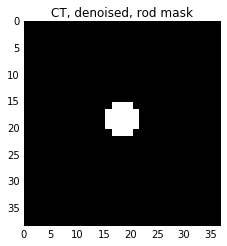

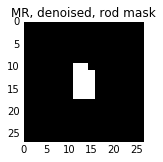

In [3]:
# set seed for segmentation
seedFillingCT = [(14,14,idxSlice)]
seedFillingMR = [(8,8,idxSlice)]

# using ConnectedThresholdImageFilter we can create a mask of just the rod
# https://itk.org/SimpleITKDoxygen/html/classitk_1_1simple_1_1ConnectedThresholdImageFilter.html
maskRodCT = sitk.ConnectedThreshold(image1=imgSmoothCT, 
                                              seedList=seedFillingCT, 
                                              lower=00, 
                                              upper=300,
                                              replaceValue=labelRod)

maskRodMR = sitk.ConnectedThreshold(image1=imgSmoothMR, 
                                              seedList=seedFillingMR, 
                                              lower=80, 
                                              upper=1500,
                                              replaceValue=labelRod)

fun.sitk_show(maskRodCT[:,:,idxSlice], title="CT, denoised, rod mask")
fun.sitk_show(maskRodMR[:,:,idxSlice], title="MR, denoised, rod mask")

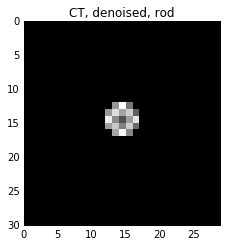

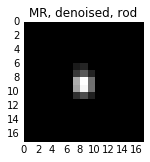

In [9]:
# now we use a custom function (see "FunctionCustom") to get rid of everything but the rod in the denoised image
# since it is denoised already, this will not make a huge difference

imgRodCT = fun.sitk_mask(imgSmoothCT, maskRodCT)
imgRodMR = fun.sitk_mask(imgSmoothMR, maskRodMR)

fun.sitk_show(imgRodCT[:,:,idxSlice], title="CT, denoised, rod")
fun.sitk_show(imgRodMR[:,:,idxSlice], title="MR, denoised, rod")

In [11]:
%env SITK_SHOW_COMMAND /home/david/Downloads/Slicer-4.5.0-1-linux-amd64/Slicer
sitk.Show(imgRodMR)

env: SITK_SHOW_COMMAND=/home/david/Downloads/Slicer-4.5.0-1-linux-amd64/Slicer


In [5]:
# important to remember:
# sitk.Image saves Volume like this (x,y,z)
# array returned by sitk.GetArrayFromImage(Image)
# is transposed: (z,y,x)

# we now use numpy to calculate the centroid of the rod
rodCT = sitk.GetArrayFromImage(imgRodCT)
zCT, yCT, xCT = np.shape(rodCT)

rodMR = sitk.GetArrayFromImage(imgRodMR)
zMR, yMR, xMR = np.shape(rodMR)

# create array with centroid of rod in each slice of CT and MRT
centroidCT = np.zeros((zCT, 2))
centroidMR = np.zeros((zMR, 2))

for slice in range(zCT):
    centroidCT[slice,:] = np.array(ndimage.measurements.center_of_mass(rodCT[slice,:,:]))

for slice in range(zMR):
    centroidMR[slice,:] = np.array(ndimage.measurements.center_of_mass(rodMR[slice,:,:]))

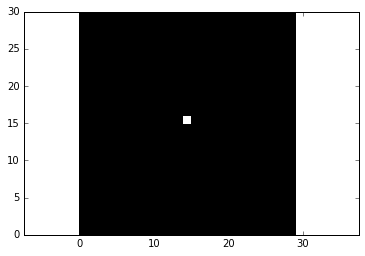

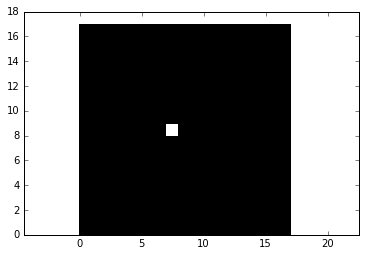

In [6]:
# to make the result visible in our image, we can set the pixel closest to the centroid to 1
# everything else will be black (value of 0)
centroidCT_int = centroidCT.astype(int)

imgCentroidCT = np.zeros((zCT, yCT, xCT))
for slice in range(zCT):
    imgCentroidCT[slice, centroidCT_int[slice,0], centroidCT_int[slice,1]] = 1
    
fun.array_show(imgCentroidCT[0,:,:])


centroidMR_int = centroidMR.astype(int)

imgCentroidMR = np.zeros((zMR, yMR, xMR))
for slice in range(zMR):
    imgCentroidMR[slice, centroidMR_int[slice,0], centroidMR_int[slice,1]] = 1
    
fun.array_show(imgCentroidMR[0,:,:])

In [8]:
# if the CT nd MR image were aligned and had the same pixel density,
# calculating the position difference in each slice would be easy